# EEG-ECG Coherence Analysis

In [16]:
import os
import shutil
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import coherence, find_peaks, hilbert, resample
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')


original_rec_path = './data/psg_ISRUC-Sleep/subgroup_1_sleep_disorder/1/1.rec'
hypnogram_path = './data/psg_ISRUC-Sleep/subgroup_1_sleep_disorder/1/1_1.xlsx'

# Define EEG Channels
eeg_channels = ['C3-A2', 'F3-A2', 'O1-A2']

# EEG frequency bands for envelope extraction
EEG_BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'sigma': (12, 16),  # Sleep spindles
    'beta': (16, 30)
}

In [17]:
# Handle .rec to .edf conversion
edf_file_path = original_rec_path.replace('.rec', '.edf')

if not os.path.exists(edf_file_path):
    print(f"Creating a copy of '{original_rec_path}' as '{edf_file_path}'...")
    shutil.copy(original_rec_path, edf_file_path)
else:
    print(f"Found '{edf_file_path}', using it for loading.")

# Load the EDF file
raw = mne.io.read_raw_edf(edf_file_path, preload=True, verbose=False)

# Load the Hypnogram
hypno_df = pd.read_excel(hypnogram_path)
sleep_stages = hypno_df['Stage'].values

# Standardize Stage Labels
stage_map = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'R': 4}
hypno_int = [stage_map.get(s, -1) for s in sleep_stages]

# Get sampling rate
fs = raw.info['sfreq']

print("\n" + "="*50)
print("DATA LOADING SUMMARY")
print("="*50)
print(f"Sampling Rate: {fs} Hz")
print(f"Total Epochs in Hypnogram: {len(sleep_stages)}")
print(f"Recording Duration: {raw.times[-1]/3600:.2f} hours")
print(f"Channel Names: {raw.ch_names}")

Found './data/psg_ISRUC-Sleep/subgroup_1_sleep_disorder/1/1.edf', using it for loading.

DATA LOADING SUMMARY
Sampling Rate: 200.0 Hz
Total Epochs in Hypnogram: 968
Recording Duration: 8.03 hours
Channel Names: ['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8']


In [18]:
# VERIFY AND SELECT ECG CHANNEL

def identify_ecg_channel(raw, candidate_channels):

    fs = raw.info['sfreq']
    results = []
    
    print("Analyzing candidate channels for ECG characteristics\n")
    
    for ch in candidate_channels:
        if ch not in raw.ch_names:
            continue
            
        # Get 60 seconds of data
        data = raw.copy().pick([ch]).get_data()[0, :int(60*fs)]
        
        # Bandpass filter for ECG (5-15 Hz to isolate QRS)
        b, a = signal.butter(2, [5, 15], btype='band', fs=fs)
        filtered = signal.filtfilt(b, a, data)
        
        # Find peaks (potential R-peaks)
        peaks, _ = find_peaks(filtered, distance=int(0.5*fs), prominence=np.std(filtered)*0.5)
        
        if len(peaks) > 10:
            rr_intervals = np.diff(peaks) / fs
            hr = 60 / np.mean(rr_intervals)
            hr_std = np.std(60 / rr_intervals)
            rr_regularity = np.std(rr_intervals) / np.mean(rr_intervals)  # CV of RR
            
            # ECG criteria: HR 40-120 BPM, relatively regular rhythm
            is_ecg = (40 < hr < 120) and (rr_regularity < 0.3)
            
            status = "✓ LIKELY ECG" if is_ecg else "✗ Unlikely ECG"
            print(f"  {ch}: HR={hr:.1f} BPM, HR_STD={hr_std:.1f}, RR_CV={rr_regularity:.3f} - {status}")
            
            if is_ecg:
                results.append((ch, hr, rr_regularity))
        else:
            print(f"  {ch}: Too few peaks detected - ✗ Unlikely ECG")
    
    return results

# Check potential ECG channels

candidate_channels = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'ECG', 'EKG']
ecg_candidates = identify_ecg_channel(raw, candidate_channels)

if ecg_candidates:
    # Sort by RR regularity (lower is better for ECG)
    ecg_candidates.sort(key=lambda x: x[2])
    ecg_channel = ecg_candidates[0][0]
    print(f"\n>>> Selected ECG channel: {ecg_channel}")
else:
    print("\n>>> WARNING: No clear ECG channel found!")
    print(">>> Using X1 as fallback - RESULTS MAY NOT BE VALID")
    print(">>> Consider using ISRUC Subgroup 3 which has documented ECG")
    ecg_channel = 'X1'

Analyzing candidate channels for ECG characteristics

  X1: HR=86.6 BPM, HR_STD=16.4, RR_CV=0.199 - ✓ LIKELY ECG
  X2: HR=71.6 BPM, HR_STD=5.8, RR_CV=0.073 - ✓ LIKELY ECG
  X3: HR=70.0 BPM, HR_STD=24.5, RR_CV=0.397 - ✗ Unlikely ECG
  X4: HR=86.1 BPM, HR_STD=17.3, RR_CV=0.200 - ✓ LIKELY ECG
  X5: HR=77.6 BPM, HR_STD=15.5, RR_CV=0.161 - ✓ LIKELY ECG
  X6: HR=77.4 BPM, HR_STD=26.0, RR_CV=0.436 - ✗ Unlikely ECG
  X7: HR=60.5 BPM, HR_STD=24.0, RR_CV=0.491 - ✗ Unlikely ECG
  X8: HR=39.7 BPM, HR_STD=34.5, RR_CV=0.599 - ✗ Unlikely ECG

>>> Selected ECG channel: X2


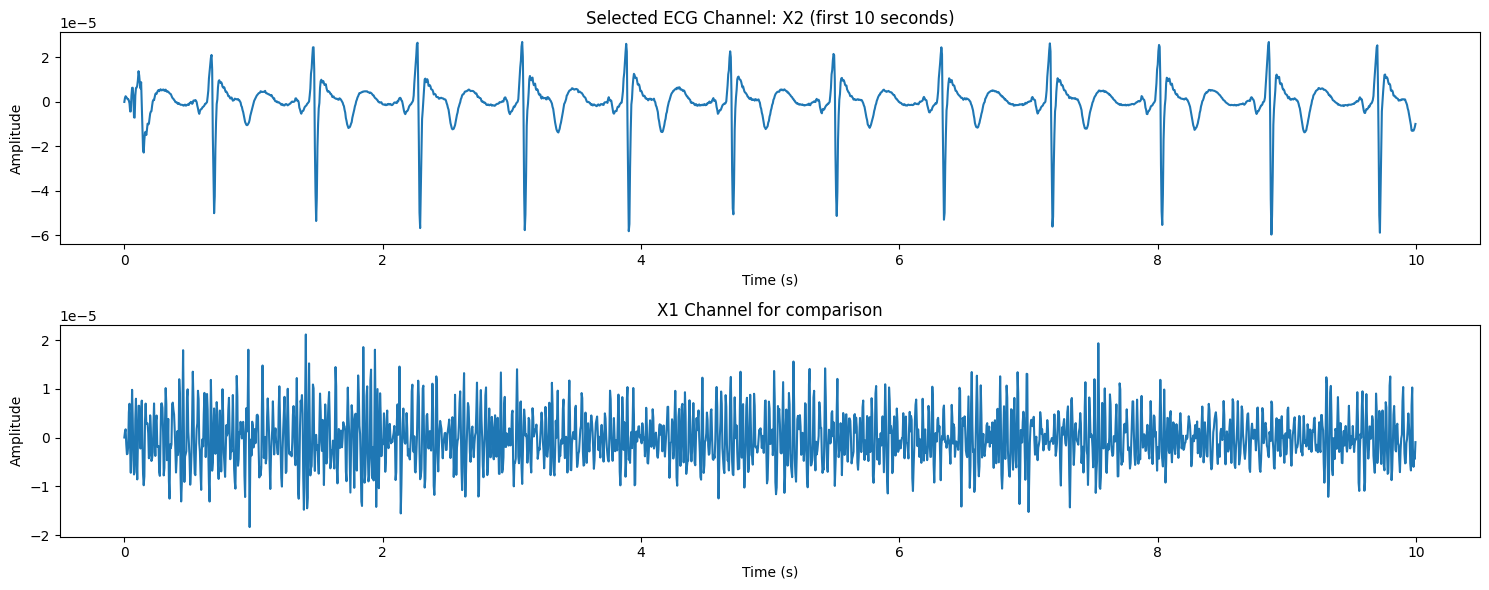

In [19]:
# Visual verification of ECG channel
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

# Plot 10 seconds of the selected ECG channel
t_plot = np.arange(int(10*fs)) / fs
ecg_data = raw.copy().pick([ecg_channel]).get_data()[0, :int(10*fs)]
axes[0].plot(t_plot, ecg_data)
axes[0].set_title(f'Selected ECG Channel: {ecg_channel} (first 10 seconds)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')

# Also plot X1 for comparison
x1_data = raw.copy().pick(['X1']).get_data()[0, :int(10*fs)]
axes[1].plot(t_plot, x1_data)
axes[1].set_title('X1 Channel for comparison')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [20]:
# SET CORRECT CHANNEL TYPES

channel_types = {}
for ch in eeg_channels:
    if ch in raw.ch_names:
        channel_types[ch] = 'eeg'

if ecg_channel in raw.ch_names:
    channel_types[ecg_channel] = 'ecg'

raw.set_channel_types(channel_types)
print(f"Channel types set: {channel_types}")

Channel types set: {'C3-A2': 'eeg', 'F3-A2': 'eeg', 'O1-A2': 'eeg', 'X2': 'ecg'}


In [21]:
raw_filtered = raw.copy()

# Filter EEG channels: 0.5-30 Hz
raw_filtered.filter(l_freq=0.5, h_freq=30.0, picks=eeg_channels, 
                    fir_design='firwin', verbose=False)

# Filter ECG channel: 0.5-45 Hz (preserve QRS complex)
raw_filtered.filter(l_freq=0.5, h_freq=45.0, picks=[ecg_channel], 
                    fir_design='firwin', verbose=False)

print(f"  EEG channels: 0.5-30 Hz")
print(f"  ECG channel: 0.5-45 Hz")

  EEG channels: 0.5-30 Hz
  ECG channel: 0.5-45 Hz


In [22]:
# Create a copy with only EEG channels for ICA fitting
raw_for_ica = raw_filtered.copy().pick(eeg_channels)

if len(eeg_channels) >= 8:
    ica = mne.preprocessing.ICA(n_components=min(15, len(eeg_channels)-1), random_state=42)
    ica.fit(raw_for_ica)
    
    # Find ECG-related components using the ECG channel from original data
    ecg_indices, ecg_scores = ica.find_bads_ecg(raw_filtered, ch_name=ecg_channel)
    ica.exclude = ecg_indices
    
    # Apply ICA only to EEG channels, leaving ECG untouched
    raw_filtered = ica.apply(raw_filtered, exclude=ecg_indices)
    
    print(f"ICA complete: removed {len(ecg_indices)} ECG-related component(s)")
else:
    print("Skipping ICA - insufficient channels (need at least 8 EEG channels)")

Skipping ICA - insufficient channels (need at least 8 EEG channels)


In [23]:

# ECG ARTIFACT REMOVAL FROM EEG (Critical for EEG-ECG coherence)

# Method: Regression-based ECG artifact removal
def remove_ecg_from_eeg_adaptive(raw, eeg_channels, ecg_channel, epoch_duration=30.0):
    """Remove ECG artifact from EEG using adaptive epoch-wise regression."""
    raw_clean = raw.copy()
    fs = raw.info['sfreq']
    samples_per_epoch = int(epoch_duration * fs)
    
    # Get ECG signal
    ecg_data = raw.copy().pick([ecg_channel]).get_data()[0]
    n_samples = len(ecg_data)
    n_epochs = n_samples // samples_per_epoch
    
    # Create delayed versions of ECG
    delays = np.arange(-20, 80)  # -50ms to +50ms at 200 Hz (wider window)
    
    for eeg_ch in eeg_channels:
        if eeg_ch not in raw.ch_names:
            continue
        
        eeg_data = raw.copy().pick([eeg_ch]).get_data()[0]
        eeg_clean = eeg_data.copy()
        
        # Process each epoch separately
        for ep in range(n_epochs):
            start = ep * samples_per_epoch
            end = start + samples_per_epoch
            
            ecg_epoch = ecg_data[start:end]
            eeg_epoch = eeg_data[start:end]
            
            # Create delayed ECG matrix properly (No circular roll)
            X_list = []
            for d in delays:
                if d == 0:
                    X_list.append(ecg_epoch)
                elif d > 0:
                    # Shift right, fill start with edge value or zero
                    X_list.append(np.pad(ecg_epoch[:-d], (d, 0), mode='edge'))
                else:
                    # Shift left (d is negative), fill end
                    X_list.append(np.pad(ecg_epoch[-d:], (0, -d), mode='edge'))
                    
            X = np.column_stack(X_list)
            
            # Fit regression
            X = np.column_stack([X, np.ones(len(eeg_epoch))])
            coeffs, _, _, _ = np.linalg.lstsq(X, eeg_epoch, rcond=None)
            
            # Subtract
            ecg_component = X @ coeffs - coeffs[-1] # Don't subtract the offset/mean
            eeg_clean[start:end] = eeg_epoch - ecg_component
        
        # Handle remaining samples
        if n_samples % samples_per_epoch > 0:
            start = n_epochs * samples_per_epoch
            # Use last epoch's coefficients for remaining samples
            eeg_clean[start:] = eeg_data[start:]  # Or apply last coeffs
        
        ch_idx = raw_clean.ch_names.index(eeg_ch)
        raw_clean._data[ch_idx] = eeg_clean
    
    return raw_clean

# Apply ECG artifact removal
raw_filtered = remove_ecg_from_eeg_adaptive(raw_filtered, eeg_channels, ecg_channel)
print("ECG artifact removal complete.")

ECG artifact removal complete.


In [24]:

# CREATE EPOCHS

# Create 30-second epochs
events = mne.make_fixed_length_events(raw_filtered, duration=30.0)
epochs = mne.Epochs(raw_filtered, events, tmin=0.0, tmax=30.0 - 1/fs, baseline=None, 
                    picks=eeg_channels + [ecg_channel], preload=True, verbose=False)

# Align with hypnogram
n_epochs = min(len(epochs), len(hypno_int))
epochs = epochs[:n_epochs]
epoch_stages = np.array(hypno_int[:n_epochs])

# Add metadata
epochs.metadata = pd.DataFrame({'stage': epoch_stages})

print(f"Created {len(epochs)} epochs of 30s length.")

Adding metadata with 1 columns
Created 964 epochs of 30s length.


In [ ]:

# ARTIFACT REJECTION (Different thresholds for EEG and ECG)

reject_criteria = dict(
    eeg=200e-6,   # 200 µV for EEG
    ecg=1e-3      # 1 mV for ECG
)

epochs.drop_bad(reject=reject_criteria, verbose=False)
print(f"Remaining epochs after artifact rejection: {len(epochs)}")

# Count epochs per stage
print("\nEpochs per sleep stage:")
for stage_name, stage_code in stage_map.items():
    count = np.sum(epochs.metadata['stage'].values == stage_code)
    print(f"  {stage_name}: {count} epochs")

Remaining epochs after artifact rejection: 964

Epochs per sleep stage:
  W: 245 epochs
  N1: 115 epochs
  N2: 345 epochs
  N3: 157 epochs
  R: 102 epochs


In [ ]:
def compute_significance_threshold(n_segments, segment_length_sec, nperseg, noverlap, fs, alpha=0.05):
    
    # Samples per segment
    n_samples = int(segment_length_sec * fs)
    
    # Number of windows per segment (with overlap)
    step = nperseg - noverlap
    n_windows_per_seg = (n_samples - nperseg) // step + 1
    
    # Total windows across all segments
    total_windows = n_segments * n_windows_per_seg
    
    # Effective DOF (reduced by overlap - approximately 50% reduction for 75% overlap)
    overlap_factor = 1 - (noverlap / nperseg) * 0.5
    effective_dof = total_windows * overlap_factor * 2  # Factor of 2 for complex signal
    
    # Significance threshold: C_thresh = 1 - alpha^(1/(L-1))
    if effective_dof > 1:
        threshold = 1 - (alpha) ** (1 / (effective_dof - 1))
    else:
        threshold = 1.0
    
    return threshold, effective_dof


# PART 1: Direct EEG-ECG Coherence Analysis

In [ ]:

from scipy.signal import detrend

fs_int = int(epochs.info['sfreq'])

# Correct nperseg based on actual sampling rate
nperseg = fs_int * 4  # 4 seconds window
noverlap = nperseg // 2

print("="*50)
print("DIRECT EEG-ECG COHERENCE ANALYSIS")
print("="*50)
print(f"Sampling rate: {fs_int} Hz")
print(f"Window size: {nperseg} samples ({nperseg/fs_int:.1f} seconds)")
print(f"Frequency resolution: {fs_int/nperseg:.3f} Hz")
print()

direct_coherence_results = {}

for stage_name, stage_code in stage_map.items():
    stage_epochs = epochs[f'stage == {stage_code}']
    
    if len(stage_epochs) == 0:
        print(f"  {stage_name}: No epochs found.")
        continue
    
    data = stage_epochs.get_data(copy=False)
    ecg_idx = stage_epochs.ch_names.index(ecg_channel)
    
    stage_coherences = {}
    
    for eeg_chan in eeg_channels:
        if eeg_chan not in stage_epochs.ch_names:
            continue
            
        eeg_idx = stage_epochs.ch_names.index(eeg_chan)
        coh_list = []

        for i in range(len(data)):
            sig_eeg = detrend(data[i, eeg_idx, :], type='linear')
            sig_ecg = detrend(data[i, ecg_idx, :], type='linear')
            
            f, Cxy = coherence(sig_eeg, sig_ecg, fs=fs_int, window='hamming', 
                               nperseg=nperseg, noverlap=noverlap)
            coh_list.append(Cxy)
        
        if coh_list:
            coh_array = np.array(coh_list)
            coh_clipped = np.clip(coh_array, 1e-10, 1 - 1e-10)
    
            # Transform to Fisher Z-space (using sqrt for magnitude-squared coherence)
            z_coh = np.arctanh(np.sqrt(coh_clipped))
            
            # Average in Z-space
            avg_z = np.mean(z_coh, axis=0)
            std_z = np.std(z_coh, axis=0)
            
            # Transform back
            avg_coh = np.tanh(avg_z) ** 2
            
            # Propagate uncertainty (first-order approximation)
            # d(tanh²)/dz = 2*tanh(z)*(1-tanh²(z))
            derivative = 2 * np.tanh(avg_z) * (1 - np.tanh(avg_z)**2)
            std_coh = np.abs(derivative) * std_z / np.sqrt(len(coh_array))
            
            stage_coherences[eeg_chan] = (f, avg_coh, std_coh)
    
    direct_coherence_results[stage_name] = stage_coherences
    print(f"  {stage_name}: Computed ({len(stage_epochs)} epochs)")

print("\nDirect coherence analysis complete.")

DIRECT EEG-ECG COHERENCE ANALYSIS
Sampling rate: 200 Hz
Window size: 800 samples (4.0 seconds)
Frequency resolution: 0.250 Hz

  W: Computed (245 epochs)
  N1: Computed (115 epochs)
  N2: Computed (345 epochs)
  N3: Computed (157 epochs)
  R: Computed (102 epochs)

Direct coherence analysis complete.


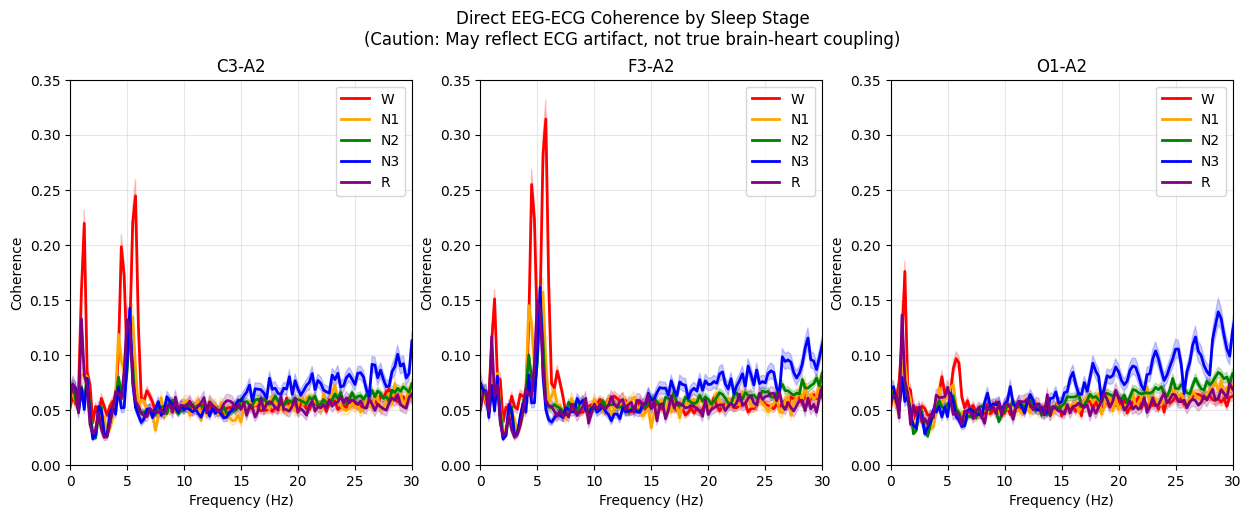

In [ ]:

# PLOT DIRECT EEG-ECG COHERENCE

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = {'W': 'red', 'N1': 'orange', 'N2': 'green', 'N3': 'blue', 'R': 'purple'}

for idx, target_channel in enumerate(eeg_channels):
    ax = axes[idx]
    
    for stage_name in stage_map.keys():
        if stage_name in direct_coherence_results and target_channel in direct_coherence_results[stage_name]:
            freqs, coh, std = direct_coherence_results[stage_name][target_channel]
            ax.plot(freqs, coh, label=stage_name, linewidth=2, color=colors[stage_name])
            ax.fill_between(freqs, coh-std, coh+std, alpha=0.2, color=colors[stage_name])
    
    ax.set_title(f'{target_channel}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Coherence')
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 0.35)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle('Direct EEG-ECG Coherence by Sleep Stage\n(Caution: May reflect ECG artifact, not true brain-heart coupling)', 
             fontsize=12, y=1.02)
#plt.tight_layout()
plt.savefig('./figures/1_direct_eeg_ecg_coherence.png', dpi=600)
plt.show()

In [ ]:
from scipy.signal import detrend

# HRV AND EEG ENVELOPE EXTRACTION FUNCTIONS


import neurokit2 as nk
from scipy.signal import firwin, filtfilt

def detect_r_peaks(ecg_signal, fs):
    
    # Bandpass filter (5-15 Hz) to isolate QRS complex
    #b, a = signal.butter(2, [5, 15], btype='band', fs=fs)
    #filtered = signal.filtfilt(b, a, ecg_signal)
    
    # Square the signal to emphasize peaks
    #squared = filtered ** 2
    
    # Moving average
    #window_size = int(0.1 * fs)  # 100ms window
    #integrated = np.convolve(squared, np.ones(window_size)/window_size, mode='same')
    
    # Find peaks with minimum distance of 0.4s (150 BPM max)
    #min_distance = int(0.4 * fs)
    #peaks, properties = find_peaks(integrated, distance=min_distance, 
    #height=np.mean(integrated) + 0.5*np.std(integrated))


    """
    Detect R-peaks in ECG signal using NeuroKit2's optimized processing pipeline.
    """
    # Clean the signal and process the peaks
    signals, info = nk.ecg_process(ecg_signal, sampling_rate=fs)
    
    # Extract R-peak indices from the 'info' dictionary
    peaks = info["ECG_R_Peaks"]
    
    return peaks




def extract_hrv_timeseries(ecg_signal, fs, target_fs=4.0):
    """
    Extract HRV time series from ECG signal with artifact correction.
    """
    r_peaks = detect_r_peaks(ecg_signal, fs)

    if len(r_peaks) < 3:
        return None, None
    
    # Calculate RR intervals (in seconds)
    rr_intervals = np.diff(r_peaks) / fs
    rr_times = r_peaks[1:] / fs  # Keep all times initially
    
    # --- Ectopic beat correction (interpolation-based) ---
    # Instead of removing invalid intervals, I replaced them with interpolated values
    median_rr = np.median(rr_intervals)
    
    # Calculate local median for adaptive thresholding
    window_size = 10  # beats
    local_median = pd.Series(rr_intervals).rolling(window_size, center=True, min_periods=3).median().values
    local_median = np.where(np.isnan(local_median), median_rr, local_median)  # Handle edges
    
    # Define ectopic beats: intervals that deviate >25% from local median
    # or are physiologically impossible
    invalid_mask = (
        (rr_intervals < 0.3) |  # > 200 BPM
        (rr_intervals > 2.0) |  # < 30 BPM
        (np.abs(rr_intervals - local_median) > 0.25 * local_median)  # >25% deviation from local median
    )
    
    if np.sum(~invalid_mask) < 2:
        return None, None
    
    # Interpolate invalid intervals using valid neighbors
    if np.any(invalid_mask):
        valid_times = rr_times[~invalid_mask]
        valid_rr = rr_intervals[~invalid_mask]
        
        if len(valid_times) >= 2:
            interp_func = interp1d(valid_times, valid_rr, kind='linear',
                                   bounds_error=False, 
                                   fill_value=(valid_rr[0], valid_rr[-1]))
            rr_intervals = interp_func(rr_times)
        else:
            return None, None
    
    # Convert to instantaneous heart rate (BPM)
    inst_hr = 60 / rr_intervals
    
    # Interpolate to uniform sampling rate
    n_samples_target = int(np.floor(len(ecg_signal) / fs * target_fs))
    t_new = np.linspace(0, (n_samples_target - 1) / target_fs, n_samples_target)
    
    # Use cubic spline interpolation
    if len(rr_times) >= 4:
        f_interp = interp1d(rr_times, inst_hr, kind='cubic', 
                           bounds_error=False, fill_value=(inst_hr[0], inst_hr[-1]))
    else:
        f_interp = interp1d(rr_times, inst_hr, kind='linear',
                           bounds_error=False, fill_value=(inst_hr[0], inst_hr[-1]))
    
    hrv_signal = f_interp(t_new)
    
    # Clip extreme values (but data should be cleaner now)
    hrv_signal = np.clip(hrv_signal, 30, 200)
    
    return hrv_signal, t_new


def extract_eeg_band_envelope(eeg_signal, fs, band, target_fs=4.0):
    """
    Extract amplitude envelope of EEG in a specific frequency band.
    """
    # Bandpass filter for the frequency band
    low, high = band
    # Reduce filter length to minimize edge effects in short epochs
    filter_length = min(int(fs * 2) + 1, int(3 * fs / low))
    if filter_length % 2 == 0:
        filter_length += 1  # Ensure odd length

    fir_coefs = firwin(numtaps=filter_length, cutoff=[low, high], pass_zero=False, fs=fs)

    # Add padding to reduce edge effects
    padlen = min(3 * len(fir_coefs), len(eeg_signal) - 1)
    filtered = filtfilt(fir_coefs, 1.0, eeg_signal, padlen=padlen)
    
    # Hilbert transform for amplitude envelope
    analytic = hilbert(filtered)
    envelope = np.abs(analytic)
    
    # Low-pass filter the envelope (< 0.5 Hz for slow fluctuations)
    anti_alias_freq = 0.9 * (target_fs / 2)
    b_lp, a_lp = signal.butter(6, anti_alias_freq, btype='low', fs=fs)  # 6th order
    envelope_smooth = signal.filtfilt(b_lp, a_lp, envelope, 
                                    padlen=min(3*max(len(b_lp), len(a_lp)), len(envelope)-1))

    # Use proper decimation instead of resample
    decimation_factor = int(fs / target_fs)
    envelope_resampled = signal.decimate(envelope_smooth, decimation_factor, ftype='fir', zero_phase=True)
    
    return envelope_resampled

def concatenate_stage_epochs(epochs, stage_code, ecg_channel, eeg_channels, max_duration=300, min_duration=120):
    """
    Concatenate consecutive epochs of the same sleep stage, ensuring temporal continuity.
    """
    # Get indices of the specific stage
    stage_mask = epochs.metadata['stage'].values == stage_code
    # I needed the absolute indices relative to the original epochs object to check events
    all_indices = np.arange(len(epochs))
    stage_indices = all_indices[stage_mask]
    
    if len(stage_indices) == 0:
        return []
    
    # Get events to check timing (Column 0 is the sample index)
    events = epochs.events
    sfreq = epochs.info['sfreq']
    expected_gap = int(30.0 * sfreq) # Assuming 30s epochs
    
    segments_list = []
    current_run = [stage_indices[0]]
    
    for i in range(1, len(stage_indices)):
        idx_curr = stage_indices[i]
        idx_prev = stage_indices[i-1]
        
        # Check if adjacent in array AND continuous in time
        is_adjacent = (idx_curr == idx_prev + 1)
        is_continuous_time = (events[idx_curr, 0] - events[idx_prev, 0] == expected_gap)
        
        if is_adjacent and is_continuous_time:
            current_run.append(idx_curr)
        else:
            # End of current run, process it
            if len(current_run) * 30 >= min_duration: # Min duration filter
                segments_list.append(current_run)
            current_run = [idx_curr]
            
    # Append last run
    if len(current_run) * 30 >= min_duration:
        segments_list.append(current_run)
    
    # Extract and Concatenate
    concatenated_segments = []
    data = epochs.get_data(copy=False)
    
    for run_indices in segments_list:
        # Enforce max_duration (e.g., 5 mins = 10 epochs)
        max_epochs = int(max_duration / 30)
        
        # Split long runs into chunks of max_duration
        for k in range(0, len(run_indices), max_epochs):
            chunk_indices = run_indices[k : k + max_epochs]
            
            if len(chunk_indices) * 30 < min_duration: # Skip leftovers < 120s
                continue
                
            # Concatenate along time axis (axis 2)
            # data shape is (epochs, channels, times)
            segment_data = np.concatenate([data[i] for i in chunk_indices], axis=1)
            concatenated_segments.append(segment_data)
            
    return concatenated_segments


HRV and EEG envelope extraction functions defined.


In [ ]:
# Adjusted parameters for longer segments
target_fs = 4.0
MIN_SEGMENT_DURATION = 90  # seconds - minimum usable segment
MAX_SEGMENT_DURATION = 300  # seconds - maximum segment (5 min)

# Window size: use 60 seconds for good LF resolution (0.017 Hz)
hrv_nperseg = int(target_fs * 60)  # 60-second window = 240 samples
hrv_noverlap = int(hrv_nperseg * 0.75)  # 75% overlap for more averaging

print("="*50)
print("HRV-BASED BRAIN-HEART COHERENCE ANALYSIS")
print("="*50)
print(f"Target sampling rate: {target_fs} Hz")
print(f"Window size: {hrv_nperseg} samples ({hrv_nperseg/target_fs:.1f} seconds)")
print(f"Frequency resolution: {target_fs/hrv_nperseg:.4f} Hz")
print(f"Frequency range: 0 - {target_fs/2} Hz (Nyquist)")
print(f"\nEEG bands analyzed: {list(EEG_BANDS.keys())}")
print()

# Store results
hrv_coherence_results = {}

# Get original sampling rate and channel indices
fs_orig = int(epochs.info['sfreq'])
all_data = epochs.get_data(copy=False)
ecg_idx = epochs.ch_names.index(ecg_channel)

for stage_name, stage_code in stage_map.items():
    
    # Get concatenated segments for this sleep stage
    MIN_SEGMENT_DURATION = 90  # Increased from 60
    segments = concatenate_stage_epochs(
        epochs, stage_code, ecg_channel, eeg_channels, 
        max_duration=MAX_SEGMENT_DURATION,
        min_duration=MIN_SEGMENT_DURATION
    )
    
    if len(segments) == 0:
        print(f"  {stage_name}: No valid segments found, skipping.")
        continue
    
    print(f"  {stage_name}: Found {len(segments)} concatenated segments")
    
    # Extract HRV from each segment
    hrv_signals = []
    valid_segments = []
    
    for seg_idx, segment_data in enumerate(segments):
        seg_duration = segment_data.shape[1] / fs_orig
        
        if seg_duration < MIN_SEGMENT_DURATION:
            continue
        
        sig_ecg = segment_data[ecg_idx, :]
        hrv_signal, _ = extract_hrv_timeseries(sig_ecg, fs_orig, target_fs)
        
        if hrv_signal is not None and len(hrv_signal) >= hrv_nperseg:
            hrv_signals.append(hrv_signal)
            valid_segments.append(segment_data)
            print(f"    Segment {seg_idx+1}: {seg_duration:.0f}s -> {len(hrv_signal)} HRV samples")
    
    if len(valid_segments) < 1:
        print(f"    -> No valid HRV segments, skipping.")
        continue
    
    # Compute coherence for each EEG channel and band
    stage_results = {}
    
    for eeg_chan in eeg_channels:
        if eeg_chan not in epochs.ch_names:
            continue
        
        eeg_idx = epochs.ch_names.index(eeg_chan)
        channel_results = {}
        
        for band_name, band_range in EEG_BANDS.items():
            coh_list = []
            
            for seg_idx, segment_data in enumerate(valid_segments):
                hrv_signal = hrv_signals[seg_idx]
                sig_eeg = segment_data[eeg_idx, :]
                
                # Extract EEG band envelope
                eeg_envelope = extract_eeg_band_envelope(sig_eeg, fs_orig, band_range, target_fs)
                
                # Ensure same length
                min_len = min(len(hrv_signal), len(eeg_envelope))
                hrv_trunc = hrv_signal[:min_len]
                eeg_trunc = eeg_envelope[:min_len]
                
                if min_len < hrv_nperseg:
                    continue
                
                # Detrend signals
                hrv_trunc = detrend(hrv_trunc, type='linear')
                eeg_trunc = detrend(eeg_trunc, type='linear')
                
                # Compute coherence
                f, Cxy = coherence(hrv_trunc, eeg_trunc, fs=target_fs,
                                   window='hamming', nperseg=hrv_nperseg,
                                   noverlap=hrv_noverlap)
                coh_list.append(Cxy)
            
            if coh_list:
                coh_array = np.array(coh_list)
                coh_clipped = np.clip(coh_array, 1e-10, 1 - 1e-10)
    
                # Transform to Fisher Z-space (using sqrt for magnitude-squared coherence)
                z_coh = np.arctanh(np.sqrt(coh_clipped))
                
                # Average in Z-space
                avg_z = np.mean(z_coh, axis=0)
                std_z = np.std(z_coh, axis=0)
                
                # Transform back
                avg_coh = np.tanh(avg_z) ** 2
                
                # Propagate uncertainty (first-order approximation)
                # d(tanh²)/dz = 2*tanh(z)*(1-tanh²(z))
                derivative = 2 * np.tanh(avg_z) * (1 - np.tanh(avg_z)**2)
                std_coh = np.abs(derivative) * std_z / np.sqrt(len(coh_array))
                
                channel_results[band_name] = (f, avg_coh, std_coh, len(coh_list))
        
        if channel_results:
            stage_results[eeg_chan] = channel_results
    
    if stage_results:
        hrv_coherence_results[stage_name] = stage_results
        n_segs = list(stage_results.values())[0][list(EEG_BANDS.keys())[0]][3]
        print(f"    -> Coherence computed ({n_segs} segments used)")

print("\nHRV-based coherence analysis complete.")

HRV-BASED BRAIN-HEART COHERENCE ANALYSIS
Target sampling rate: 4.0 Hz
Window size: 240 samples (60.0 seconds)
Frequency resolution: 0.0167 Hz
Frequency range: 0 - 2.0 Hz (Nyquist)

EEG bands analyzed: ['delta', 'theta', 'alpha', 'sigma', 'beta']

  W: Found 26 concatenated segments
    Segment 1: 300s -> 1200 HRV samples
    Segment 2: 300s -> 1200 HRV samples
    Segment 3: 300s -> 1200 HRV samples
    Segment 4: 300s -> 1200 HRV samples
    Segment 5: 300s -> 1200 HRV samples
    Segment 6: 300s -> 1200 HRV samples
    Segment 7: 300s -> 1200 HRV samples
    Segment 8: 300s -> 1200 HRV samples
    Segment 9: 300s -> 1200 HRV samples
    Segment 10: 300s -> 1200 HRV samples
    Segment 11: 300s -> 1200 HRV samples
    Segment 12: 180s -> 720 HRV samples
    Segment 13: 300s -> 1200 HRV samples
    Segment 14: 300s -> 1200 HRV samples
    Segment 15: 300s -> 1200 HRV samples
    Segment 16: 300s -> 1200 HRV samples
    Segment 17: 300s -> 1200 HRV samples
    Segment 18: 150s -> 600 HR

In [ ]:
# After computing coherence, calculate threshold:
sig_thresh, eff_dof = compute_significance_threshold(
    n_segments=len(coh_list),
    segment_length_sec=300,  # Average segment length
    nperseg=hrv_nperseg,
    noverlap=hrv_noverlap,
    fs=target_fs
)
print(f"Significance threshold (p<0.05): {sig_thresh:.4f}, Effective DOF: {eff_dof:.1f}")

Significance threshold (p<0.05): 0.0128, Effective DOF: 233.8


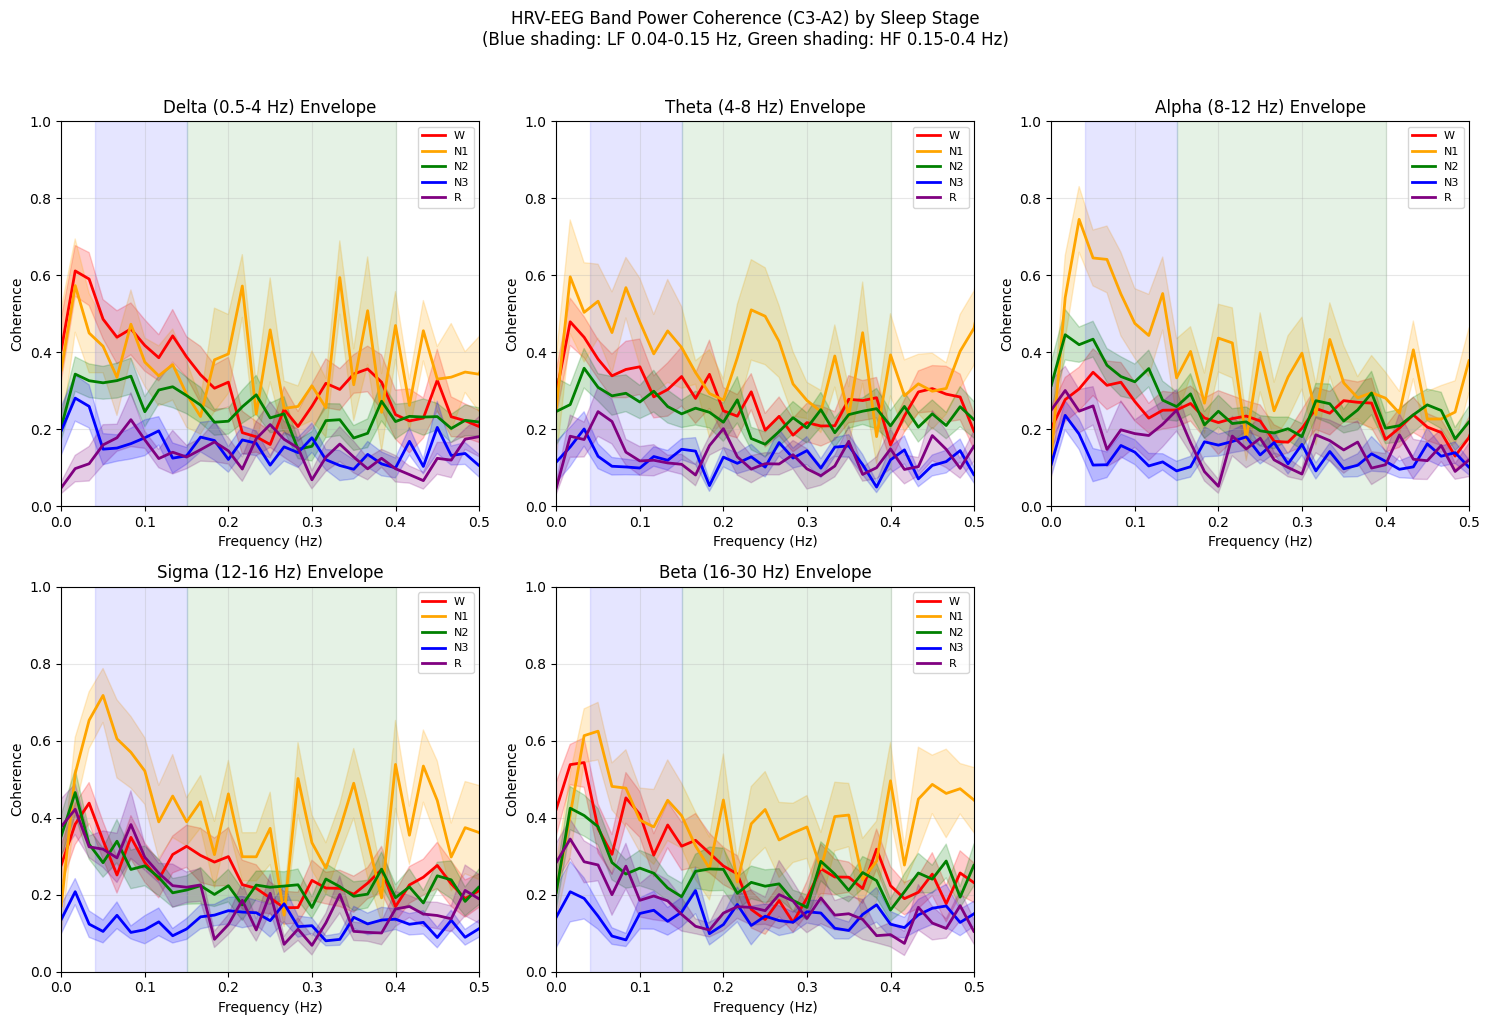

In [ ]:
# PLOT HRV-EEG COHERENCE BY FREQUENCY BAND


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

colors = {'W': 'red', 'N1': 'orange', 'N2': 'green', 'N3': 'blue', 'R': 'purple'}
target_channel = 'C3-A2'

for idx, (band_name, band_range) in enumerate(EEG_BANDS.items()):
    ax = axes[idx]
    
    for stage_name in stage_map.keys():
        if (stage_name in hrv_coherence_results and 
            target_channel in hrv_coherence_results[stage_name] and
            band_name in hrv_coherence_results[stage_name][target_channel]):
            
            freqs, coh, std, _ = hrv_coherence_results[stage_name][target_channel][band_name]
            ax.plot(freqs, coh, label=stage_name, linewidth=2, color=colors[stage_name])
            ax.fill_between(freqs, coh-std, coh+std, alpha=0.2, color=colors[stage_name])
    
    ax.set_title(f'{band_name.capitalize()} ({band_range[0]}-{band_range[1]} Hz) Envelope')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Coherence')
    ax.set_xlim(0, 0.5)  # Focus on very low frequencies
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Mark HRV frequency bands
    ax.axvspan(0.04, 0.15, alpha=0.1, color='blue', label='LF')
    ax.axvspan(0.15, 0.4, alpha=0.1, color='green', label='HF')

# Remove empty subplot
axes[5].axis('off')

plt.suptitle(f'HRV-EEG Band Power Coherence ({target_channel}) by Sleep Stage\n'
             f'(Blue shading: LF 0.04-0.15 Hz, Green shading: HF 0.15-0.4 Hz)', 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig('./figures/2_hrv_eeg_coherence.png', dpi=600)
plt.show()

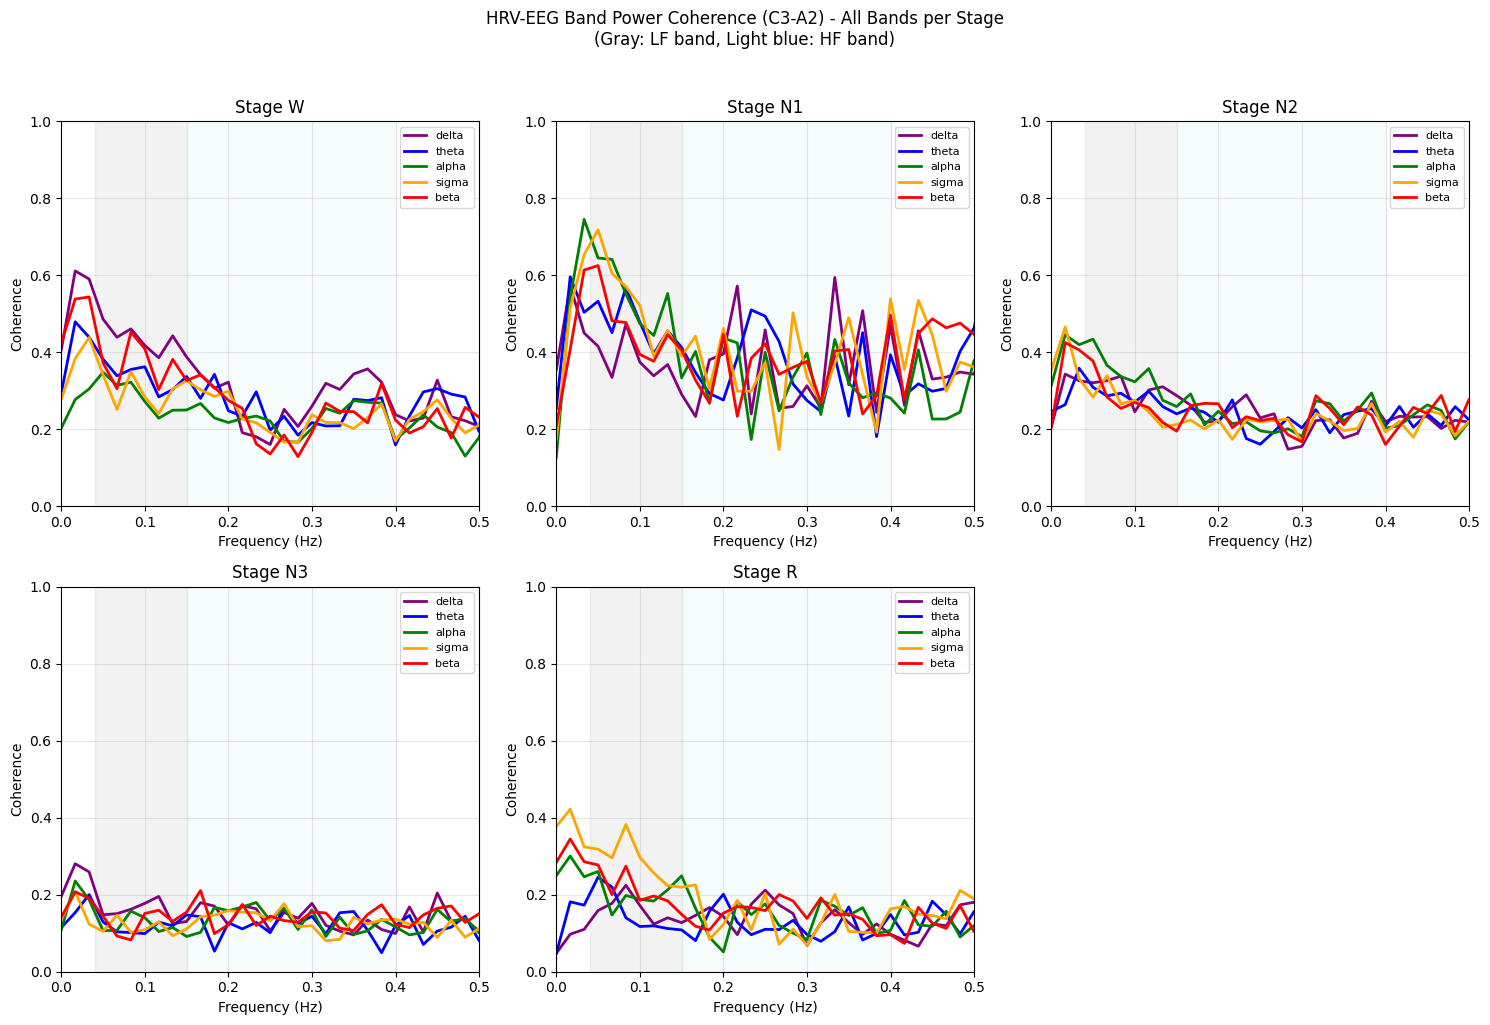

In [ ]:
# PLOT HRV-EEG COHERENCE BY SLEEP STAGE


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

band_colors = {'delta': 'purple', 'theta': 'blue', 'alpha': 'green', 
               'sigma': 'orange', 'beta': 'red'}
target_channel = 'C3-A2'

stage_list = list(stage_map.keys())

for idx, stage_name in enumerate(stage_list):
    ax = axes[idx]
    
    if (stage_name in hrv_coherence_results and 
        target_channel in hrv_coherence_results[stage_name]):
        
        for band_name in EEG_BANDS.keys():
            if band_name in hrv_coherence_results[stage_name][target_channel]:
                freqs, coh, std, n_epochs = hrv_coherence_results[stage_name][target_channel][band_name]
                ax.plot(freqs, coh, label=band_name, linewidth=2, color=band_colors[band_name])
    
    ax.set_title(f'Stage {stage_name}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Coherence')
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Mark HRV frequency bands
    ax.axvspan(0.04, 0.15, alpha=0.1, color='gray')
    ax.axvspan(0.15, 0.4, alpha=0.1, color='lightblue')

axes[5].axis('off')

plt.suptitle(f'HRV-EEG Band Power Coherence ({target_channel}) - All Bands per Stage\n'
             f'(Gray: LF band, Light blue: HF band)', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig('./figures/3_hrv_eeg_coherence.png', dpi=600)
plt.show()

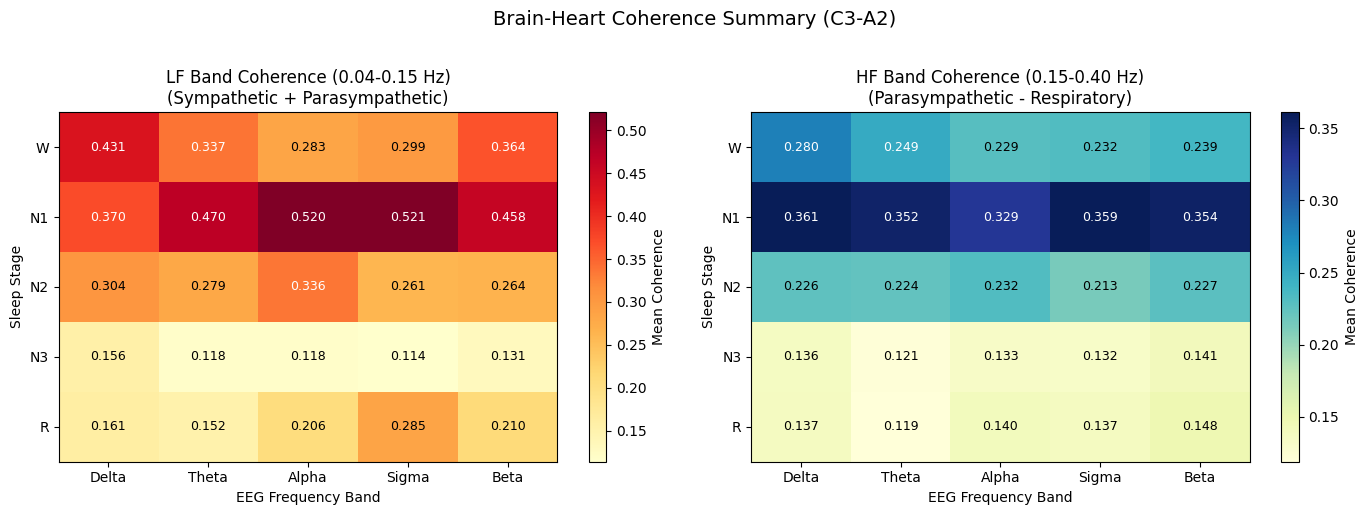

In [ ]:
# SUMMARY HEATMAP: MEAN COHERENCE IN LF AND HF BANDS


def get_band_mean_coherence(freqs, coh, freq_range):
    """Calculate mean coherence within a frequency range."""
    mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(coh[mask])

# HRV frequency bands
LF_RANGE = (0.04, 0.15)  # Low Frequency (sympathetic + parasympathetic)
HF_RANGE = (0.15, 0.40)  # High Frequency (parasympathetic)

def add_heatmap_text(ax, data):
    vmin, vmax = np.nanmin(data), np.nanmax(data)
    mid = (vmin + vmax) / 2

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if not np.isnan(data[i, j]):
                color = 'white' if data[i, j] > mid else 'black'
                ax.text(
                    j, i,
                    f'{data[i, j]:.3f}',
                    ha='center',
                    va='center',
                    fontsize=9,
                    color=color
                )


target_channel = 'C3-A2'

# Create summary matrices
stages = list(stage_map.keys())
bands = list(EEG_BANDS.keys())

lf_matrix = np.zeros((len(stages), len(bands)))
hf_matrix = np.zeros((len(stages), len(bands)))

for i, stage_name in enumerate(stages):
    for j, band_name in enumerate(bands):
        if (stage_name in hrv_coherence_results and 
            target_channel in hrv_coherence_results[stage_name] and
            band_name in hrv_coherence_results[stage_name][target_channel]):
            
            freqs, coh, _, _ = hrv_coherence_results[stage_name][target_channel][band_name]
            lf_matrix[i, j] = get_band_mean_coherence(freqs, coh, LF_RANGE)
            hf_matrix[i, j] = get_band_mean_coherence(freqs, coh, HF_RANGE)
        else:
            lf_matrix[i, j] = np.nan
            hf_matrix[i, j] = np.nan

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LF coherence heatmap
im1 = axes[0].imshow(lf_matrix, cmap='YlOrRd', aspect='auto')
axes[0].set_xticks(range(len(bands)))
axes[0].set_xticklabels([b.capitalize() for b in bands])
axes[0].set_yticks(range(len(stages)))
axes[0].set_yticklabels(stages)
axes[0].set_xlabel('EEG Frequency Band')
axes[0].set_ylabel('Sleep Stage')
axes[0].set_title(f'LF Band Coherence (0.04-0.15 Hz)\n(Sympathetic + Parasympathetic)')
plt.colorbar(im1, ax=axes[0], label='Mean Coherence')

# Add values to cells
#for i in range(len(stages)):
#    for j in range(len(bands)):
#        if not np.isnan(lf_matrix[i, j]):
#            axes[0].text(j, i, f'{lf_matrix[i, j]:.3f}', ha='center', va='center', fontsize=9, color='white')

# HF coherence heatmap
im2 = axes[1].imshow(hf_matrix, cmap='YlGnBu', aspect='auto')
axes[1].set_xticks(range(len(bands)))
axes[1].set_xticklabels([b.capitalize() for b in bands])
axes[1].set_yticks(range(len(stages)))
axes[1].set_yticklabels(stages)
axes[1].set_xlabel('EEG Frequency Band')
axes[1].set_ylabel('Sleep Stage')
axes[1].set_title(f'HF Band Coherence (0.15-0.40 Hz)\n(Parasympathetic - Respiratory)')
plt.colorbar(im2, ax=axes[1], label='Mean Coherence')

# Add values to cells
#for i in range(len(stages)):
#    for j in range(len(bands)):
#        if not np.isnan(hf_matrix[i, j]):
#            axes[1].text(j, i, f'{hf_matrix[i, j]:.3f}', ha='center', va='center', fontsize=9, color='white')

add_heatmap_text(axes[0], lf_matrix)
add_heatmap_text(axes[1], hf_matrix)

plt.suptitle(f'Brain-Heart Coherence Summary ({target_channel})', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('./figures/4_brain_heart_coherence.png', dpi=600)
plt.show()

In [ ]:
# EXPORT RESULTS TO CSV


# Create summary DataFrame
results_list = []

for stage_name in stages:
    for eeg_chan in eeg_channels:
        for band_name in bands:
            if (stage_name in hrv_coherence_results and 
                eeg_chan in hrv_coherence_results[stage_name] and
                band_name in hrv_coherence_results[stage_name][eeg_chan]):
                
                freqs, coh, std, n_epochs = hrv_coherence_results[stage_name][eeg_chan][band_name]
                
                lf_coh = get_band_mean_coherence(freqs, coh, LF_RANGE)
                hf_coh = get_band_mean_coherence(freqs, coh, HF_RANGE)
                
                results_list.append({
                    'Stage': stage_name,
                    'EEG_Channel': eeg_chan,
                    'EEG_Band': band_name,
                    'LF_Coherence': lf_coh,
                    'LF_Coherence_SEM': get_band_mean_coherence(freqs, std, LF_RANGE),  # ADD THIS
                    'HF_Coherence': hf_coh,
                    'HF_Coherence_SEM': get_band_mean_coherence(freqs, std, HF_RANGE),  # ADD THIS
                    'N_Epochs': n_epochs
                })

results_df = pd.DataFrame(results_list)
results_df.to_csv('brain_heart_coherence_results.csv', index=False)

print("Results exported to 'brain_heart_coherence_results.csv'")
print("\nSummary Table:")
print(results_df.to_string(index=False))

Results exported to 'brain_heart_coherence_results.csv'

Summary Table:
Stage EEG_Channel EEG_Band  LF_Coherence  LF_Coherence_SEM  HF_Coherence  HF_Coherence_SEM  N_Epochs
    W       C3-A2    delta      0.431047          0.062099      0.280447          0.056191        26
    W       C3-A2    theta      0.337218          0.064699      0.248619          0.054906        26
    W       C3-A2    alpha      0.283209          0.051056      0.228797          0.050016        26
    W       C3-A2    sigma      0.299337          0.050576      0.232239          0.052422        26
    W       C3-A2     beta      0.363916          0.059756      0.238979          0.047887        26
    W       F3-A2    delta      0.388670          0.057474      0.243128          0.048894        26
    W       F3-A2    theta      0.253162          0.047848      0.207165          0.041809        26
    W       F3-A2    alpha      0.243500          0.050688      0.193087          0.045163        26
    W       F3-A2  